# Imaging Lab 2: Single Pixel Scanning

### EECS 16A: Designing Information Devices and Systems I, Fall 2018

**Name 1**:

**Login**: ee16a-ama


**Name 2**:

**Login**: ee16a-aho


## Table of Contents

* [Instructions](#instructions)
* [Lab Policies](#policies)
* [Hardware Setup](#setup)
* Images, Vectors, and Matrices
    * [Working with Images](#task2a)
    * [Scanning Mask Matrix](#task2b)
* [Imaging Real Pictures](#task3)
* [FAQ](#faq)

<a id='instructions'></a>
## Instructions
* Complete this lab by filling in all of the required sections, marked with `"YOUR CODE HERE"` or `"YOUR COMMENTS HERE"`.


* When you finish, submit a checkoff request to get checked off for this lab. Be ready to answer a few questions to show your understanding of each section.


* Labs will be graded based on completion for teams of 2 (or 3) students.

<a id='policies'></a>
## Lab Policies
* **YOU MUST ATTEND THE LAB SECTION YOU ARE ENROLLED IN. If you anticipate missing a section, please notify your GSI in advance.**
* **You are required to return all parts checked out at the beginning of the lab section unless told otherwise.**
* **You are free to stay for the full allotted time and hack around with the lab equipment, but please keep the GSI's time in mind and do not work on unrelated assignments.**
* **Food and drinks (except water) are not allowed in the lab.**
* **Clean up, turn off all equipment, and log off of computers before leaving.**

# Overview
<center>
<img src="images/system_diagram.svg" style="height:256px" />
</center>
This week, you will scan a real-life image pixel-by-pixel using a projector and light sensor circuit (a.k.a. **single pixel camera**), and you will write code to display the captured image in your Jupyter (iPython) notebook. You will begin by checking that the circuit you built last time (with minor modifications) works and that the projector is properly connected to the computer. Next, you will write code to generate the "mask" patterns that the projector uses to scan the image. Then, you will use your generated mask matrix to photograph an image with the projector and ambient light sensor setup (seen below). Finally, you will write code to recreate the image from light sensor readings that are sent to your computer via the Launchpad.
<br><br>
<center>
**Cory 140 Setup**
<img src="images/side.png" style="height:350px" />
<br>
**Cory 125 Setup**
<img src="images/125_setup.jpg" style="height:350px" />
</center>

##  <span style="color:red">**IMPORTANT**</span>: <a id ='setup'><span style = "color: blue">Hardware Setup</span></a>

# Please follow instructions here ( [Cory 140](ee16a_imaging_setup_140.pdf) [Cory 125](ee16a_imaging_setup_125.pdf) ) *verbatim* to get consistent results. Having a good setup will make taking the picture much easier and cleaner. The box should in the top left of your station.

In [2]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats
%matplotlib inline

# Images, Vectors, and Matrices

<a id='task2a'></a>
## <span style="color:blue">Working with Images</span>
A simple grayscale image can be represented using a 2D numpy array (matrix). The values stored in this array correspond to different shades of gray, where lower numbers correspond to darker pixels and higher numbers correspond to lighter pixels.  

To see how this works, create a 5x5 numpy array called **`gradient_image`** with *linearly spaced* floating point values from 0 to 1. This means that gradient_image[0, 0] = 0.0, gradient_image[2, 2] = 0.5, and gradient_image[4,4] = 1.0.

** <span style="color:red">Create the gradient 5x5 array here. It should look like the following:</span>**
<br/><br/>
<center>
<img src="images/gradient.JPG" align="center" style="height:200px" />
</center>

*Hint: Google the functions `np.linspace` (which creates a vector of equally spaced values over a specified range) and `np.reshape`!*

[[0.         0.04166667 0.08333333 0.125      0.16666667]
 [0.20833333 0.25       0.29166667 0.33333333 0.375     ]
 [0.41666667 0.45833333 0.5        0.54166667 0.58333333]
 [0.625      0.66666667 0.70833333 0.75       0.79166667]
 [0.83333333 0.875      0.91666667 0.95833333 1.        ]]


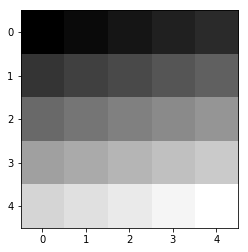

In [6]:
# TODO: Make a 5x5 gradient image with values from 0 to 1.
gradient_image = np.linspace(0, 1, num=25) # YOUR CODE HERE

gradient_image = np.reshape(gradient_image, (5,5))
print(gradient_image)
plt.imshow(gradient_image, cmap = 'gray', interpolation="nearest")

**<span style="color:red">What color does 1.0 correspond to? What about 0?</span>**

1.0 corresponds to white, and 0 corresponds to black.

**NOTE**: In lecture, we have been using 1 indexing for our vectors. In lab, we will be using 0 indexing, as most programming languages index in lists starting from 0.

Let's suppose the 2D image we want to "scan" with our single pixel camera is **`gradient_image`**. What would the same image look like if it were instead represented by a 1D column vector **`gradient_image_vector`**? 
<center>
<img src="images/matrix_to_col.png" style="width:500px"/>
</center>

Let's look at the 3x3 example image above (colored for illustrative purposes). Essentially, the $0$th row is flipped on its side, such that its left-most element is on top and its right-most element is on the bottom. The $1$st row is also flipped on its side in the same way and appended below. These steps are repeated for each subsequent row of the original 2D image until you build a `num_pixels` $\times 1$ **column vector**.

In matrix form, each pixel value in the 3x3 image is represented as a variable $iv_{ij}$, where $i$ is the row and $j$ is the column associated with the pixel location. This same image represented as a 1D column vector (called $\vec{i}$) is:

$$\vec{i} = \begin{bmatrix} iv_{00} \\ iv_{01} \\ iv_{02} \\ iv_{10} \\ iv_{11} \\ iv_{12} \\ iv_{20} \\ iv_{21} \\ iv_{22} \end{bmatrix}$$

**<span style="color:red">Convert the 5x5 `gradient_image` that you created above into a 25x1 column vector `gradient_image_vector` and display it. You will find the command `np.reshape` helpful. What do you notice?</span>**

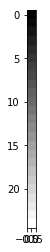

In [7]:
# TODO: Convert the 5x5 matrix into a 25x1 column vector
gradient_image_vector = gradient_image.reshape(25, 1)

# Display the vector
plt.imshow(gradient_image_vector, cmap='gray', interpolation="nearest")

<a id='task2b'></a>
## <span style="color:blue">Scanning Mask Matrix</span>

Next, we will create a "mask" array (matrix) to enable our projector to illuminate and scan individual pixels, one at a time. This is the magic behind our single pixel camera. 

What matrix $H$ multiplied with **`gradient_image_vector`** will return **`gradient_image_vector`**? If **`gradient_image_vector`** is represented by the column vector variable $\vec{i}$, the act of transforming $\vec{i}$ by a matrix $H$ into another 1D column vector $\vec{s}$ is represented mathematically as:

$$ \vec{s} = H \vec{i} $$

This matrix multiplication represents what happens when we scan an image with our single pixel camera! In the context of our imaging system, $H$ represents the scanning "mask matrix," whose rows are projected one-by-one onto the image we want to scan. $\vec{s}$ represents digitized readings from our light sensor. Each element $sr_k$ of $\vec{s}$ corresponds to one scan (using one row $k$ of $H$, that we refer to as $H_k$). 

Each 1D **row of $H$** represents a **mask**. But what is a mask? In the context of our single pixel camera, a mask is a way to hide certain elements of the image while scanning. For a 3x4 image (where 3 = height, 4 = width to match Numpy array indexing), a mask taken from **row 0 of $H$** is represented as the $12 \times 1$ row vector below: 

$$
H_0 
= \begin{bmatrix} 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\end{bmatrix}
$$

However, the mask must first be converted into its 2D form, as shown below, before it's projected over the 2D image. The mask exposes only the top-left pixel of the 2D image and hides all other pixels. Note that you can convert a 2D mask into a 1D row of $H$ by appending each of the 2D mask's rows to the right of the previous row.
<br><br>
<center>
<img src="images/black_hite.png" style="width:400px"/>
</center>
 
To expose each pixel of the 3x4 image $\vec{i}$ individually, we would need a 12x12 $H$ that has 12 masks (rows), each with a single white "exposed" pixel in a unique location. This means that **row 1 of $H$** (exposing $iv_{01}$) would look like:

$$
H_1 
= \begin{bmatrix} 0 & 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\end{bmatrix}
$$

The process of masking an image, one pixel at a time, and sensing the resultant ambient light performs the matrix multiplication $\vec{s} = H \vec{i}$ in real life. This equation implies that each element of the sensor reading column vector $\vec{s}$ can be determined as:
    
$$sr_k = H_k \vec{i}$$

Where the $k$th sensor reading is determined by the $k$th row of $H$, $H_k$. Thus, projecting the 2D representation of $H_0$ shown above onto a 3x4 image represented by the column vector $\vec{i}$ to obtain the sensor reading $sr_0$ would be mathematically equivalent to:

$$
sr_0 = \begin{bmatrix} 1 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\end{bmatrix} \vec{i}
$$

**<span style="color:red">
What dimensions does the mask matrix $H$ for a 5x5 image have and why? </span>**

$H$ should be 25x25 because: (1) each row represents(masks) one unique pixel, and there are $5*5 = 25$ pixels; (2) every row in $H$ can be represented as a 5x5 image that, in real imaging, would be projected over gradient_image.

**<span style="color:red">
Create the mask matrix $H$ for the 5x5 image.</span>**

*Hint: Google the function `np.eye`.*

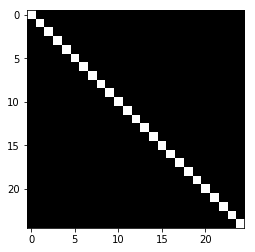

In [8]:
# TODO: Create the mask matrix `H` for scanning a 5x5 image (be careful about the dimensions!)
H = np.eye(25) # YOUR CODE HERE

# Display this matrix
plt.imshow(H, cmap = 'gray', interpolation="nearest")

**<span style="color:red">
Multiply the $H$ matrix with `gradient_image_vector` to get the same vector back! Remember to use `np.dot` to do matrix multiplication.</span>**

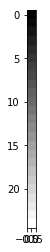

In [9]:
# TODO: Recreate gradient_image_vector by multiplying `H` and `gradient_image_vector`
gradient_image_recreate = np.dot(H, gradient_image_vector) # YOUR CODE HERE

# Display the result and compare it to `gradient_image_vector`
plt.imshow(gradient_image_recreate, cmap = 'gray', interpolation="nearest")

What is happening when this matrix multiplication is performed? To reiterate, each row of $H$ is responsible for "illuminating," or selecting, a single pixel in the gradient image! `gradient_image_vector` was created by converting the 5x5 `gradient_image` into a 1D *column vector*. Similarly, *every row* in $H$ can be represented as a 5x5 image that, in real imaging, would be projected over `gradient_image`. 

**<span style="color:red">
Iterate through each row of the matrix $H$. *Reshape* each row into a 5x5 image, and check that each row illuminates a unique pixel of the original 5x5 image! Based on $ \vec{s} = H \vec{i} $, why are the rows of $H$ used for masking when $\vec{i}$ is a column vector?</span>**

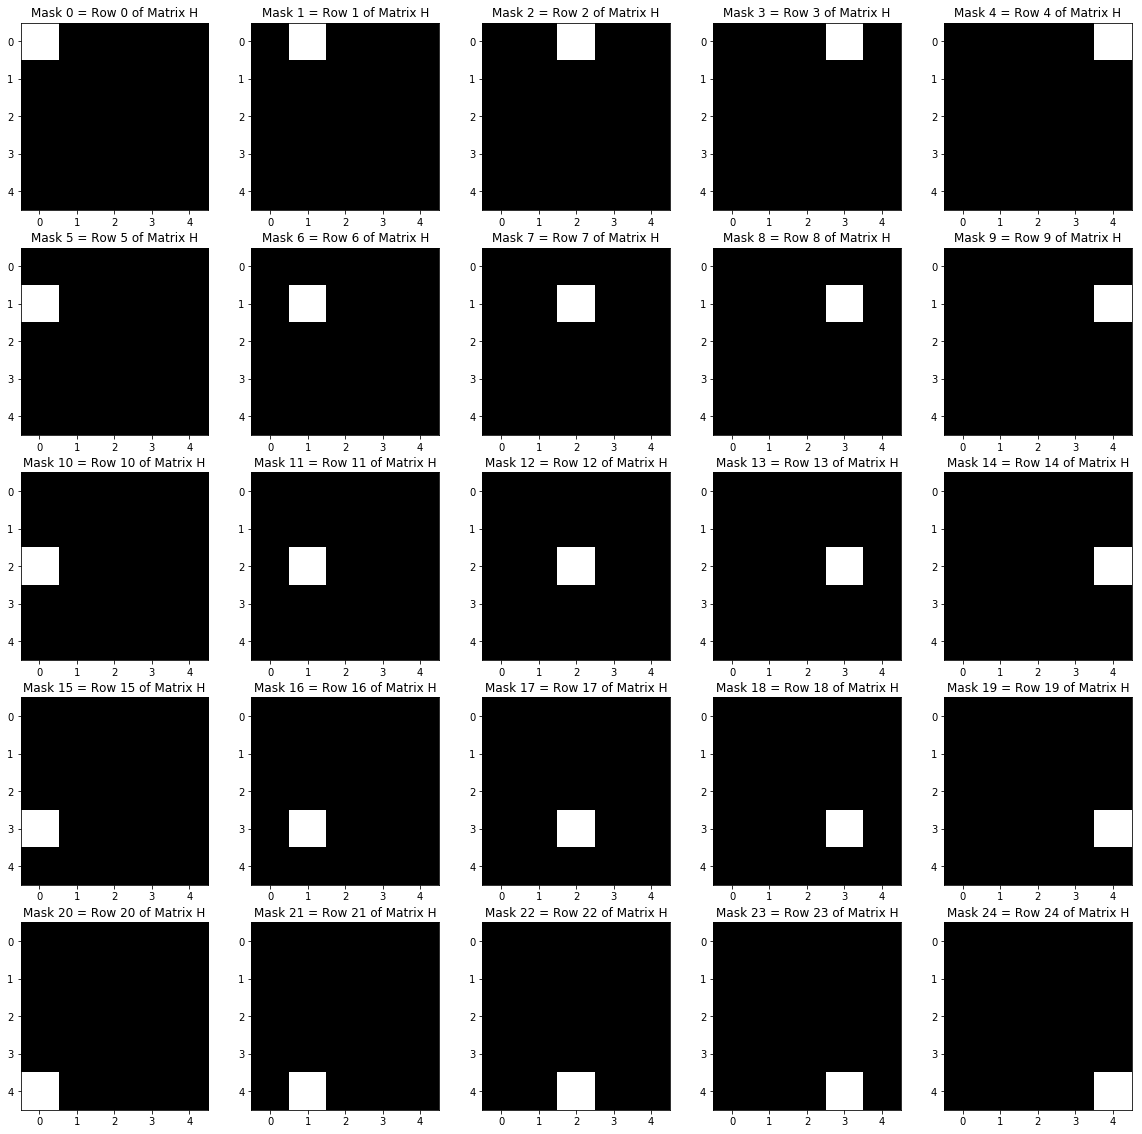

In [11]:
# Iterate through rows of matrix H and form individual masks
plt.figure(figsize = (20, 20)) 
for k in range(25):
    plt.subplot(5, 5, k + 1)
    
    mask = H[k].reshape(5, 5) # YOUR CODE HERE
    
    plt.imshow(mask, cmap = 'gray', interpolation="nearest")
    plt.title('Mask ' + str(k) + ' = Row ' + str(k) + ' of Matrix H')

Each of the images above are masks. During a single scan, we project one of these masks over our image. The white pixel illuminates a particular location on the image that we want to capture, and the black pixels obscure the other parts of the image. Thus, using the rows of $H$, we gather information one pixel at a time.

Let's try to make a mask matrix that's a little more complicated. We want the first half of $\vec{s}$ to contain information on every other pixel of the image (i.e. $iv_{00}$, $iv_{02}$, $iv_{04}$). The second half of $\vec{s}$ should consist of information on the pixels that the first half skipped (i.e. $iv_{01}$, $iv_{03}$, $iv_{10}$).

**<span style="color:red">
Generate `H_Alt` whose first half (in terms of rows) illuminates every other pixel of $\vec{i}$ and whose second half illuminates the pixels that were skipped. Multiply `H_Alt` by `gradient_image_vector` to produce the `s` described previously.
</span>**

*Hint: Try to use rows from the existing H matrix. Review the Python tutorial. Also, look up `np.concatenate` (if you want to try some clever array slicing) or use for loop(s).*

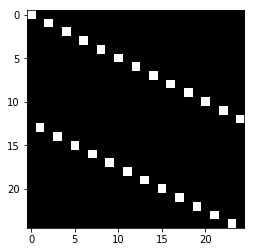

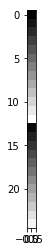

In [26]:
# TODO: Create the new mask matrix `H_Alt`
helper1 = np.zeros(325).reshape(13, 25)
helper2 = np.zeros(300).reshape(12, 25)

for i in range(13):
    helper1[i][2*i] = 1
    
for i in range(12):
    helper2[i][2*i + 1] = 1

H_Alt = np.concatenate((helper1, helper2), axis=0) # YOUR CODE HERE

# Display `H_Alt`
plt.figure()
plt.imshow(H_Alt, cmap = 'gray', interpolation="nearest")

# TODO: Multiply `H_Alt` and `gradient_image_vector`
s =  np.dot(H_Alt, gradient_image_vector) # YOUR CODE HERE

# Display the result `s` and compare to `gradient_image_vector`
plt.figure()
plt.imshow(s, cmap = 'gray', interpolation="nearest")

Because of how we designed `H_Alt`, `s` is clearly different from `gradient_image_vector`. Each pixel of `gradient_image_vector` is still illuminated only once by `H_Alt`, but the order in which the pixels are illuminated has changed. Therefore, we say that `s` is a "scrambled" version of `gradient_image_vector`. How would we go about performing a "reconstruction" step that transforms the column vector `s` back into `gradient_image_vector`? Recall that our original `H` was actually the **identity** matrix $I_n$. 
 
$$M \vec{s} = M H_{Alt} \vec{i} = I_n \vec{i} = \vec{i} $$

**<span style="color:red">What should M be to recover $\vec{i}$?</span>**

Similar to the elementary matrix $E$ we created in HW3 P2, we could let M be an elementary matrix that reconstructs the gradient_image_vector.

**<span style="color:red">Write code to reconstruct `gradient_image_vector` from `s`.</span>**

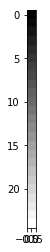

In [27]:
# TODO: Reconstruct `gradient_image_vector`
M = np.array([
    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
])
gradient_image_vector_reconstruct = np.dot(M, s) # YOUR CODE HERE

# Display the result
plt.imshow(gradient_image_vector_reconstruct, cmap = 'gray', interpolation="nearest")

<a id='task3'></a>
## <span style="color:blue">Imaging Real Pictures</span>

Finally, we will use our two matrices to image a real picture. Because our picture is fairly large, we want each individual mask to have dimensions 30x40 (i.e. height = 30, width = 40) to match the 4:3 (W:H) aspect ratio of the projector. Think about how big the mask matrix was for the 5x5 example. How big must it be for a 30x40 picture?

**<span style="color:red">
Recreate both the $H$ and $H_{Alt}$ masks to match these new dimensions. </span>**

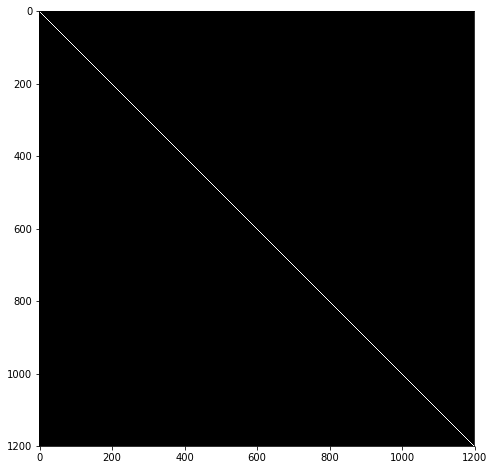

In [28]:
# TODO: Recreate `H`
H = np.identity(1200) # YOUR CODE HERE
plt.figure(figsize = (8, 8))
plt.imshow(H, cmap = 'gray', interpolation="nearest")

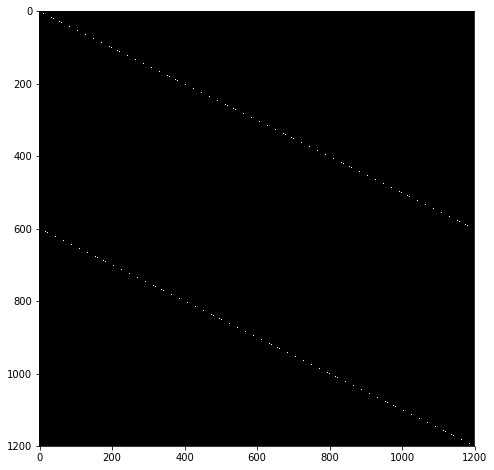

In [29]:
# TODO: Recreate `H_Alt`
helper1 = np.zeros(720000).reshape(600, 1200)
helper2 = np.zeros(720000).reshape(600, 1200)

for i in range(600):
    helper1[i][2*i] = 1
    
for i in range(600):
    helper2[i][2*i + 1] = 1

H_Alt = np.concatenate((helper1, helper2), axis=0) # YOUR CODE HERE

plt.figure(figsize = (8,8))
plt.imshow(H_Alt, cmap = 'gray', interpolation="nearest")

Our mask matrices must be saved as files before they can be used to perform real imaging. The files are read by our imaging script, as seen below. 

**<span style="color:red">Run the cell below to save `H` and `H_Alt`!</span>**

In [30]:
np.save('H.npy', H)
np.save('H_Alt.npy', H_Alt)

Now, we need an object to take a picture of. There are index cards and markers at the GSI desk; **<span style="color:red">take an index card and draw something on its blank (no lines) side. Place this index card inside the box so that the projector can project onto it</span>** (see the Overview image). 

**<span style="color:green">Setup A</span>**: You can either tape the index card to the side of the box that the projector is projecting onto or you can insert the index card into slots at the far end of the stand (if possible).

**<span style="color:blue">Setup B</span>**: You'll need to tape the index card to the side of the box that the projector is projecting onto. 

Tape is on the TA desk; do not take the whole dispenser.

**<span style="color:red">Double check that you've done the following before proceeding:</span>**

* Upload `AnalogReadSerial` to the Launchpad.

* Close out of the Energia Serial Monitor.

* Make sure that the ambient light sensor is aimed at the center of the index card! The legs should not be touching.

* Seal the imaging system inside the box to keep ambient light out during scanning. If the holes for cables are too big, try to have them face a solid, unmoving object that can block out light.

**<span style="color:red">You will then run the `capture_image.py` script bellow that projects mask patterns onto your image based on the $H$ matrix that you designate. This script controls the scanning process.</span>** 

In the code block below, the `--mask` tag points to the file (including the npy extension) associated with the mask matrix you want to use. The `--out` tag tells the script where you want to save the column vector sensor data. (The "out" file name doesn't include the npy extension, as it's automatically appended. Additionally, info about the capture settings, like projector brightness, is also appended to the file name. We'll take care of this for you.)

When running **`capture_image.py`**, a new icon shaped like a white web will appear in the taskbar. The window depicting our masks will appear on the projector's screen. *You can confirm this by looking into the box. (Don't forget to close the box when you're done checking!)*

Before scanning, you will be prompted to specify the **COM port used by the Launchpad and the display associated with the projector.** 

**Select the COM port associated with UART1 (previously accessed in the Energia Serial Monitor and found using the Device Manager) and the 1280x720 projector screen.** Note that you want to specify the index of your choice i.e. for `2) 1280 x 720`, specify 2. **<span style="color:red">Make sure that you selected the correct COM port!</span>**

`capture_image.py` iterates over the rows of the $H$ matrix you made. These rows are translated, one-by-one, into real masks projected onto the screen. Light sensor readings are taken for each mask. At the start of the scan, you'll see a series of `Loc: # Data: #` printed to the output below. `Loc` corresponds to the index $k$ of the current sensor reading (and likewise current row of H). `Data` corresponds to the actual digitized value obtained from the light sensor. This "debug" information is printed consecutively for the first few/last few sensor outputs. Otherwise, this info is printed when `k % 100 = 0` (every 100 scans). 

Don't worry about messages like `Time delta between captures in s: #`. This is printed a lot because the lab computers are slow. Make sure you followed the hardware setup near the beginning - restart your MSP by unplugging and replugging it in after programming it.

The whole scanning process should take roughly 3 minutes. 

Running the code block below will start your scan - **don't** click on the window popup.

In [31]:
# Import necessary libraries (so you don't have to start from the top)
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats
%matplotlib inline

%run capture_image.py --mask H.npy --out sensor_readingsH

ModuleNotFoundError: No module named 'serial'

**<span style="color:red">Not getting a good picture?</span>**

If you selected the incorrect COM port, a lot more "debug" lines will be dumped. You might notice `Data: -1` or `Losing data! Consider increasing your timeout!` messages. Once you see these messages, **save** your Jupyter notebook, then **close the ipython notebook in terminal (Ctrl+C twice) and re-open it**. You'll lose any saved variables (not output images), but everything you need has been saved to a file. Rerun the following code block again, but **make sure you select the right COM port**. 

After the sensor readings have been captured, load the sensor reading vector into the cell below. Once again, here is the equation relating $H$, the sensor reading column vector $\vec{s}$, and the image column vector $\vec{i}$:

$$\vec{s} = H \vec{i}$$

**<span style="color:red">Recreate the image from the sensor readings obtained with `H`.</span>**

In [ ]:
# Sensor readings
sr = np.load('sensor_readingsH_100_0.npy')
H = np.load('H.npy')

# TODO: Create the image vector from `H` and `sr`
# Hint: Because `H` is a special matrix, technically you do not need to perform any matrix operations
iv = # YOUR CODE HERE 

img = np.reshape(iv, (30, 40))
plt.figure(figsize = (8, 8))
plt.imshow(img, cmap = 'gray', interpolation="nearest")

Congratulations! You have imaged your first image using your single pixel camera! 

**<span style="color:red">
Does your recreated image match the real image? What are some problems you notice? 
</span>**

Here is an example of a picture we took using this setup:

<center>
<img src="images/ee16a_picture.png"/>
</center>

**<span style="color:red">Next, use the second mask `H_Alt` for imaging. Can you repeat the same reconstruction procedure just by replacing $H$ with $H_{Alt}$? Why or why not?</span>**

Run `capture_image.py` again (taking the same precautions as above) to collect sensor readings. Make sure to run it from the code block below to point the script to `H_Alt`. Then reconstruct the image.

In [ ]:
# Import necessary libraries (so you don't have to start from the top)
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats
%matplotlib inline

%run capture_image.py --mask H_Alt.npy --out sensor_readingsHAlt

In [ ]:
# Sensor readings
sr = np.load('sensor_readingsHAlt_100_0.npy')
H_Alt = np.load('H_Alt.npy')

# TODO: Create the image vector from `H_Alt` and `sr`
# Hint: You need to perform a matrix operation before multiplying
iv = # YOUR CODE HERE 

img = np.reshape(iv, (30, 40))
plt.figure(figsize = (8, 8))
plt.imshow(img, cmap = 'gray', interpolation="nearest")

You are done for the week! Save your code and circuit for next week, where you will illuminate multiple pixels per mask!

#### You are ready to sign up for checkoff. DO NOT disassemble your circuit before checking off. Afterwards, you may take the Launchpad and circuit kit with you. Remember to bring it back next week!

<a id='checkoff'></a>
## Checkoff
When you are ready to get checked off, please have each person in your group fill out the [Check Off Form](https://goo.gl/forms/baVOSNCUs7YwjeMi2). Follow the form exactly and submit. Your GSI or a Lab Assistant will come by once they are available and go through some checkoff questions with your group. Do not take apart your setup before being checked off.